In [1]:
import os
from collections import OrderedDict
import numpy as np
import pandas as pd
from scipy import ndimage
import random
import bloscpack as bp

import matplotlib.pyplot as plt
import cv2
import imgaug as ia
import imgaug.augmenters as iaa

import torch
from torch import nn
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms as pttf

import fastai
from fastai.vision import *

# from optim import Over9000

from data import Bengaliai_DS
# from senet_mod import seresxt50
# from models_mg import mdl_ResDenHybrid
# from senet_mod import SENetMod

# from model_utils import *

# from senet_mod import se_resnext50_32x4d

# from torchvision.models import densenet169

In [11]:
from models_mg import mdl_res34_localpool

In [12]:
a = mdl_res34_localpool()

In [14]:
a.load_state_dict(torch.load('mdl_res34localpool_168168_lessaugs_mucm_fixed_adam_onecycle_fld3of5.pth'))

<All keys matched successfully>

In [2]:
from torchvision.models import densenet121, resnet34

In [2]:
# a = resnet34()
# b = densenet121()
a = mdl_ResDenHybrid()

In [4]:
# b = torch.nn.Sequential(*list(list(a.children())[0].children())[5:-1])
# b = torch.nn.Sequential(*list(a.children())[:-2])
c = torch.nn.Sequential(*list(a.children())[:8])

In [3]:
arr_in = torch.from_numpy(np.random.rand(10, 1, 128, 128)).float()

In [4]:
a(arr_in)[0].shape

torch.Size([10, 168])

In [8]:
b[2].shape

torch.Size([10, 7])

In [2]:
trn_imgs = bp.unpack_ndarray_from_file('../features/train_images_raw_64112.bloscpack')
# see preprocess notebook, it's shown that the train.csv data sequence is the same and can just load like this.
trn_lbls = pd.read_csv('../input/train.csv').iloc[:, 1:4].values

In [3]:
ndcs = iter(np.arange(trn_imgs.shape[0]))

6


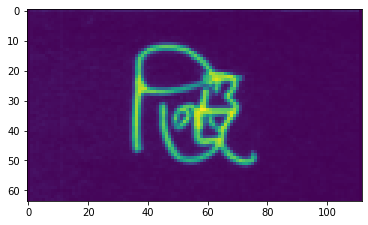

In [10]:
ndx = next(ndcs)
print(ndx)
img = trn_imgs[ndx]
plt.imshow(img)

In [6]:
rows = np.any(img>50, axis=1)
cols = np.any(img>5, axis=0)
rmin, rmax = np.where(rows)[0][[0, -1]]
cmin, cmax = np.where(cols)[0][[0, -1]]

In [10]:
cmax

167

In [61]:
# augs = iaa.SomeOf(
#     (1, 2),
#     [
#         iaa.OneOf(
#             [
#                 iaa.Affine(scale={"x": (0.85, 1.15), "y": (0.85, 1.15)}, rotate=(-20, 20), shear=(-20, 20)),
#                 iaa.PerspectiveTransform(scale=.08, keep_size=True),
#             ]
#         ),
#         iaa.PiecewiseAffine(scale=0.03),
#     ],
#     random_order=True
# )
# augs = iaa.Cutout(nb_iterations=1, position='uniform', size=0.8, squared=False, fill_mode='constant', cval=128)

# augs= iaa.SomeOf(
#     (0, 2),
#     [
#         iaa.Affine(scale={"x": (0.85, 1.15), "y": (0.85, 1.15)}, rotate=(-20, 20), shear=(-20, 20)), # , translate_percent={"x": (-.15, .15), "y": (-.15, .15)}
#         iaa.PerspectiveTransform(scale=.1, keep_size=True),
#     ],
#     random_order=True
# )

# augs = iaa.OneOf(
#     [
#         iaa.Affine(
#             scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
#             rotate=(-10, 10),
#             shear={'x': (-10, 10), 'y': (-10, 10)},
#         ),
#         iaa.PerspectiveTransform(scale=.08, keep_size=True),
#     ]
# )

# augs = iaa.SomeOf(
#     (0, 2),
#     [
#         iaa.OneOf(
#             [
#                 iaa.Affine(
#                     scale={"x": (0.8, 1.), "y": (0.8, 1.)},
#                     rotate=(-15, 15),
#                     shear={'x': (-15, 15), 'y': (-15, 15)},
#                 ),
#                 iaa.PerspectiveTransform(scale=.08, keep_size=True),
#             ]
#         ),
#         iaa.OneOf(
#             [
#                 iaa.BlendAlphaVerticalLinearGradient(iaa.TotalDropout(1.0), min_value=0.1, max_value=0.9), 
#                 iaa.BlendAlphaHorizontalLinearGradient(iaa.TotalDropout(1.0), min_value=0.1, max_value=0.9),
#                 iaa.DirectedEdgeDetect(alpha=(.01, .99), direction=(0.0, 1.0)),
#             ]
#         ),
#     ],
#     random_order=True,
# )

augs = iaa.SomeOf(
    (0, 2),
    [
        iaa.OneOf(
            [
                iaa.Affine(rotate=(-15, 15), shear={'x': (-10, 10), 'y': (-10, 10)}),
                iaa.PerspectiveTransform(scale=.08, keep_size=True),
            ]
        ),
        iaa.DirectedEdgeDetect(alpha=.1, direction=(0.0, 1.0)),
    ],
    random_order=True
)


# augs = iaa.PerspectiveTransform(scale=.08, keep_size=True)
# augs = None

In [62]:
test_ds = Bengaliai_DS(trn_imgs, trn_lbls, transform=augs)

In [5]:
ndx_iter = iter(range(0, 50000))

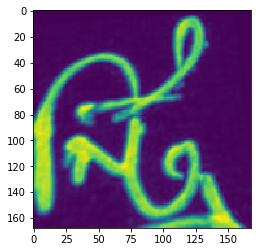

In [81]:
ndx = next(ndx_iter)
tst_img, tst_lbl = test_ds[ndx]
# tst_img = augs(image=tst_img.astype('uint8')[0])
# tst_img = cv2.erode(tst_img, np.ones((2, 2), np.uint8), iterations=1)
plt.imshow(tst_img[0])

In [5]:
test_loader = DataLoader(test_ds, batch_size=64, num_workers=4, shuffle=True)

In [7]:
for a_raw, b in test_loader:
    break

In [9]:
a = a_raw[:]

In [11]:
from mixup_fastai_utils import random_half_FlantIndices

In [12]:
ndcs, _ = random_half_FlantIndices(a.shape)

In [13]:
ndcs = torch.from_numpy(ndcs)

In [14]:
shuffle = torch.randperm(a.size(0)).to(a.device)
a1 = a[shuffle]

In [15]:
a.view(-1)[ndcs] = a1.view(-1)[ndcs]

In [16]:
a_np = a.cpu().numpy()

In [17]:
a_np.shape

(64, 1, 96, 96)

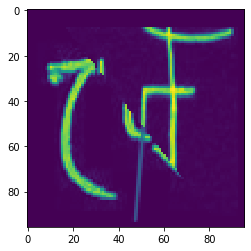

In [127]:
plt.imshow(a_np[random.randint(0, 63), 0])

In [138]:
def grid_mask(image):
    assert len(image.shape) == 2
    h, w = img.shape

    mask = np.zeros((h*2, w*2))

    density_h = random.randint(h//8, h//4)
    density_w = random.randint(w//8, w//4)
    factor_h = random.randint(2, 3)
    factor_w = random.randint(2, 3)

    mask[::density_h, ::density_w] = 1

    mask = cv2.dilate(mask, np.ones((density_h//factor_h, density_w//factor_w), np.uint8), iterations=1)

    mask = np.round(ndimage.rotate(mask, random.randint(-10, 10), reshape=False))
    
    mask = mask[h//2:h+h//2, w//2:w+w//2]
                    
    return mask

In [1164]:
%%timeit
msk = grid_mask(img)

2.68 ms ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [63]:
tsfm(img).max()

tensor(1.)

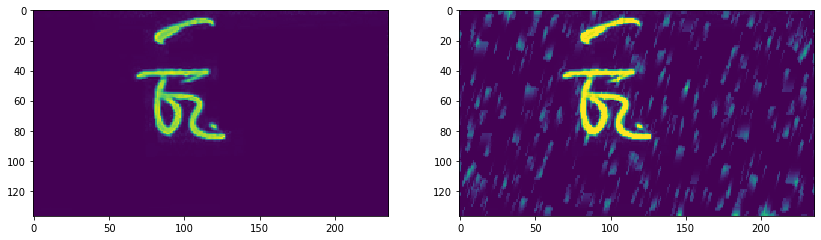

In [120]:
img = trn_imgs[ndx]
# img[:3, :] = 0
# img[-3:, :] = 0
# img[:, :3] = 0
# img[:, -3:] = 0
# k = np.ones((2, 2), np.uint8)
# if random.randint(0, 1):
#     img = cv2.dilate(img, k, iterations=1)
# else:
#     img = cv2.erode(img, k, iterations=1)
img_aug = augs(image=img)
# img_aug = tsfm(img).numpy().squeeze()
# msk = grid_mask(img)
# img_aug[msk == 1] = 0
_, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].imshow(img)
ax[1].imshow(img_aug)
# ax[2].imshow(msk)

In [291]:
kernel = np.ones((random.randint(2, 3), random.randint(2, 3)), np.uint8)

In [302]:
if random.randint(0, 1):
    print(1)

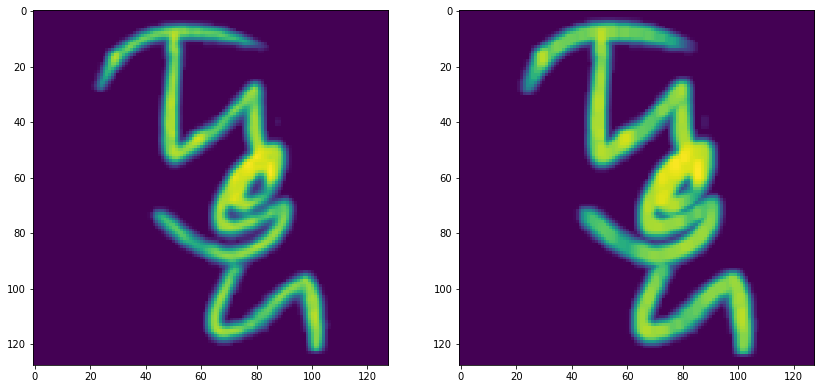

In [292]:
img = trn_imgs[ndx]
# img_aug = cv2.erode(img, kernel, iterations=1)
img_aug = cv2.dilate(img, kernel, iterations=1)
# img_cln = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
# img_aug = augs(image=img)
_, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].imshow(img)
ax[1].imshow(img_aug)

In [2]:
predictor = PretrainedCNN(out_dim=168+11+7)
base_model = BengaliClassifier(predictor)

In [3]:
a = list(predictor.children())

In [ ]:
a[1].features

In [57]:
a[2]

Sequential(
  (0): LinearBlock(
    (linear): Linear(in_features=2048, out_features=512, bias=True)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): LinearBlock(
    (linear): Linear(in_features=512, out_features=186, bias=True)
    (bn): BatchNorm1d(186, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [44]:
b = list(a[1].children())

In [59]:
tst_mdl = torch.nn.Sequential(*b[:-2])

In [69]:
tst_mdl_cls = torch.nn.Sequential(*([torch.nn.functional.] + b[-2:]))

In [75]:
tst_mdl_all = torch.nn.Sequential(*b)

In [66]:
c = np.random.rand(10, 3, 168, 168)

In [67]:
d = tst_mdl(torch.from_numpy(c).float())

In [68]:
d.shape

torch.Size([10, 2048, 6, 6])

In [80]:
e = b[-2](torch.from_numpy(c).float())
e.shape

torch.Size([10, 3, 162, 162])

In [94]:
f = predictor.base_model.features(torch.from_numpy(c).float())

In [95]:
f.shape

torch.Size([10, 2048, 6, 6])

---

In [67]:
def rand_bboxes_FlantIndices(size, lam):
    H = size[2]
    W = size[3]
    
    index_addition = np.arange(size[0]) * H * W
    
    cut_ratios = np.sqrt(1. - lam)
    cut_ws = np.round(W * cut_ratios).astype(int)
    cut_hs = np.round(H * cut_ratios).astype(int)

    # uniform
    cx = np.random.randint(W, size=cut_ratios.shape[0])
    cy = np.random.randint(H, size=cut_ratios.shape[0])

    bbx0s = np.clip(cx - cut_ws // 2, 0, W)
    bby0s = np.clip(cy - cut_hs // 2, 0, H)
    bbx1s = np.clip(cx + cut_ws // 2, 0, W)
    bby1s = np.clip(cy + cut_hs // 2, 0, H)
    
    multi_indices = [np.meshgrid(np.arange(x0, x1), np.arange(y0, y1)) for x0, x1, y0, y1 in zip(bbx0s, bbx1s, bby0s, bby1s)]
    multi_indices_rvl = [np.ravel_multi_index(lst[::-1], (H, W)).flatten() for lst in multi_indices]
    
    boxes_in_flattened_indices = np.concatenate([index_r + addition for index_r, addition in zip(multi_indices_rvl, index_addition)])
    new_lambda = 1 - ((bbx1s - bbx0s) * (bby1s - bby0s) / (H * W))
    
    return boxes_in_flattened_indices, new_lambda

In [99]:
a = torch.from_numpy(np.zeros((64, 1, 128, 128)))
b = torch.from_numpy(np.ones((64, 1, 128, 128)))

In [ ]:
lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))

In [70]:
shuffle = torch.randperm(a.size(0)).to(a.device)
a_wip = a[shuffle]

In [71]:
flattened_indices, lambd = rand_bboxes_FlantIndices(a.size(), lambd)

In [89]:
flattened_indices

array([  10256,   10257,   10258,   10259, ..., 1045116, 1045117, 1045118, 1045119])

In [103]:
a_newview = a.view(-1)

In [104]:
a_newview[torch.from_numpy(flattened_indices)] = b.view(-1)[torch.from_numpy(flattened_indices)]

In [95]:
a_newview[10255:10257]

tensor([0., 1.], dtype=torch.float64)

In [105]:
c = a[0, 0].detach().numpy()

In [106]:
c.max()

1.0

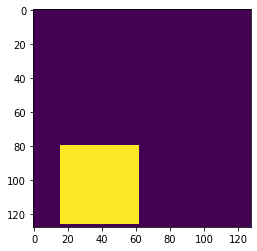

In [107]:
plt.imshow(c)

In [1]:
W = H = 10

In [16]:
index_addition = np.arange(15) * H * W

In [63]:
lambd = np.random.beta(.4, .4, 15)
lambd

array([0.454367, 0.998082, 0.730278, 0.048381, 0.017645, 0.135105, 0.039587, 0.919232, 0.043179, 0.935284, 0.539664,
       0.97293 , 0.306828, 0.022268, 0.013022])

In [5]:
cut_rat = np.sqrt(1. - lambd)
cut_rat

array([0.556331, 0.78666 , 0.44614 , 0.621908, 0.298942, 0.966279, 0.890548, 0.006874, 0.996638, 0.964848, 0.898965,
       0.017129, 0.968496, 0.596709, 0.346339])

In [8]:
cut_w = np.round(W * cut_rat).astype(int)
cut_h = np.round(H * cut_rat).astype(int)
cut_w

array([ 6,  8,  4,  6,  3, 10,  9,  0, 10, 10,  9,  0, 10,  6,  3])

In [9]:
cx = np.random.randint(W, size=cut_rat.shape[0])
cy = np.random.randint(H, size=cut_rat.shape[0])
cx

array([8, 6, 7, 8, 5, 4, 6, 4, 0, 7, 0, 5, 5, 1, 6])

In [ ]:
bbx1 = np.clip(cx - cut_w // 2, 0, W)
bby1 = np.clip(cy - cut_h // 2, 0, H)
bbx2 = np.clip(cx + cut_w // 2, 0, W)
bby2 = np.clip(cy + cut_h // 2, 0, H)

In [64]:
lambd0 = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (H * W))

In [66]:
len(lambd0)

15

In [36]:
for i, (y1, y2, x1, x2) in enumerate(zip(bby1, bby2, bbx1, bbx2)):
    print(i, ':', '\t', y1, '\t', y2, '\t', x1, '\t', x2)

0 : 	 3 	 9 	 5 	 10
1 : 	 0 	 4 	 2 	 10
2 : 	 0 	 4 	 5 	 9
3 : 	 2 	 8 	 5 	 10
4 : 	 0 	 2 	 4 	 6
5 : 	 0 	 9 	 0 	 9
6 : 	 0 	 8 	 2 	 10
7 : 	 7 	 7 	 4 	 4
8 : 	 3 	 10 	 0 	 5
9 : 	 0 	 6 	 2 	 10
10 : 	 5 	 10 	 0 	 4
11 : 	 4 	 4 	 5 	 5
12 : 	 1 	 10 	 0 	 10
13 : 	 3 	 9 	 0 	 4
14 : 	 5 	 7 	 5 	 7


In [11]:
multi_indices = [np.meshgrid(np.arange(x1, x2), np.arange(y1, y2)) for x1, x2, y1, y2 in zip(bbx1, bbx2, bby1, bby2)]

In [13]:
multi_indices[0]

[array([[5, 6, 7, 8, 9],
        [5, 6, 7, 8, 9],
        [5, 6, 7, 8, 9],
        [5, 6, 7, 8, 9],
        [5, 6, 7, 8, 9],
        [5, 6, 7, 8, 9]]), array([[3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6],
        [7, 7, 7, 7, 7],
        [8, 8, 8, 8, 8]])]

In [14]:
np.ravel_multi_index(multi_indices[0][::-1], (H, W)).flatten()

array([35, 36, 37, 38, 39, 45, 46, 47, 48, 49, 55, 56, 57, 58, 59, 65, 66, 67, 68, 69, 75, 76, 77, 78, 79, 85, 86, 87,
       88, 89])

In [15]:
multi_indices_r = [np.ravel_multi_index(lst[::-1], (H, W)).flatten() for lst in multi_indices]

In [17]:
flattened_indices = np.concatenate([indices_r + addition for indices_r, addition in zip(multi_indices_r, index_addition)])

In [18]:
flattened_indices

array([  35,   36,   37,   38, ..., 1455, 1456, 1465, 1466])

In [22]:
aaa = np.zeros((15, 1, 10, 10))
bbb = aaa.flatten()
bbb[flattened_indices] = 1
ccc = bbb.reshape(*aaa.shape)

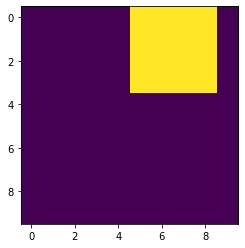

In [35]:
plt.imshow(ccc[2, 0])

---

In [6]:
SEED = 20190819

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

---
### data

In [2]:
trn_imgs = bp.unpack_ndarray_from_file('../features/train_images_size128_pad0.bloscpack')
# see preprocess notebook, it's shown that the train.csv data sequence is the same and can just load like this.
trn_lbls = pd.read_csv('../input/train.csv').iloc[:, 1:4].values

In [423]:
augs = iaa.SomeOf(
    (0, 3),
    [
        iaa.OneOf(
            [
                iaa.Affine(scale={"x": (0.8, 1.1), "y": (0.8, 1.1)}, rotate=(-15, 15), shear=(-15, 15)),
                iaa.PiecewiseAffine(scale=(0.02, 0.03)),
                iaa.PerspectiveTransform(scale=.09, keep_size=True),
            ]
        ),
        iaa.GaussianBlur(sigma=(0.5, 1.)),
#         iaa.OneOf(
#             [
#                 iaa.GaussianBlur(sigma=(0.5, 1.)),
#                 iaa.MotionBlur(k=(7, 13), angle=[-45, 45]),
#                 iaa.MedianBlur(k=(3, 5)),
#             ]
#         ),
        iaa.OneOf(
            [
                iaa.DirectedEdgeDetect(alpha=(.6, .8), direction=(0.0, 1.0)),
                iaa.Emboss(alpha=(.5, 1.), strength=(.1, 4)),
            ]
        ),
#         iaa.CoarseDropout((0.05, 0.15), size_percent=(0.15, 0.35)),
#         iaa.Fog(),
    ],
    random_order=True
)

In [24]:
import cv2

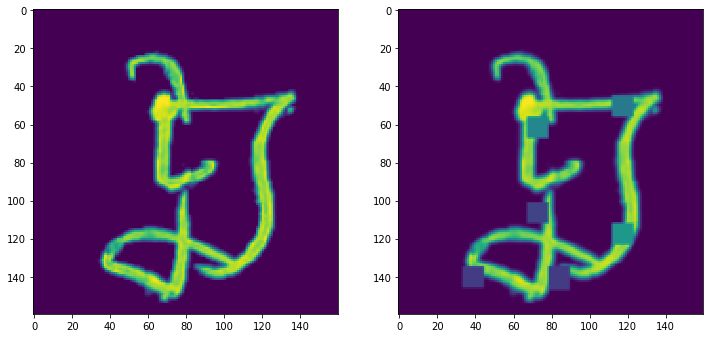

In [420]:
# kernel = np.ones((3, 3), np.uint8)
# def augs(image): return cv2.erode(image, kernel, iterations=1)
augs = iaa.Superpixels(p_replace=0.1, n_segments=(64, 256))
img_arr = training_set[2048][0][0][0]
# img_arr = np.stack([img_arr, img_arr, img_arr], -1)
# img_arr = img_arr[np.newaxis, :]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
aug_img = augs(image=img_arr.astype('uint8'))
ax[0].imshow(img_arr.astype('uint8'))
ax[1].imshow(aug_img)

In [3]:
training_set = Bengaliai_DS(trn_imgs[:160000, np.newaxis], trn_lbls[:160000], transform=None, scale=False, norm=False)
# validation_set = DS_TRN(trn_imgs[160000:, np.newaxis], trn_lbls[160000:])

# training_loader = DataLoader(training_set, batch_size=64, shuffle=True, num_workers=4)
# validation_loader = DataLoader(validation_set, batch_size=64, shuffle=False, num_workers=4)

# dat_bunch = DataBunch(train_dl=training_loader, valid_dl=validation_loader)

---
### model

In [9]:
device = 'cuda:0'
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant

In [10]:
predictor = PretrainedCNN(out_dim=n_total)
classifier = BengaliClassifier(predictor)#.to(device)

In [11]:
learn = Learner(
    dat_bunch,
    classifier,
    loss_func=Loss_combine(),
    opt_func=Over9000,
    metrics=[Metric_grapheme(), Metric_vowel(), Metric_consonant(),Metric_tot()]
)

logger = CSVLogger(learn, 'Seresnext_DensenetStarterSetup_Myaugs')

learn.clip_grad = 1.0
learn.split([classifier.predictor.lin_layers])
# learn.split([classifier.head1])
learn.unfreeze()